In [1]:
"""
@author: Jackson Wilt, Nico Schramma & Vera Horjus
"""

'\n@author: Jackson Wilt, Nico Schramma & Vera Horjus\n'

# Marangoni boat project code

Welcome to this notebook with code to be used for the data analysis of the boats :) This notebook contains code adapted from original code written by Jackson Wilt and Nico Schramma.
<br />
This notebook contains all data you can use for analysis of the boats, with some comments on how it works. Feel free to copy the notebook and make changes or adaptations however you see fit.

In [2]:
# Importing relevant packages
import cv2
import numpy as np
import pims
import trackpy as tp
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

## Loading in video
In the cell below you can put the name of the video you want to be analysed. Make sure you put the video in the same folder as where the file with this code is put.

In [3]:
fileName = r'Tracking_videos\7-4-2025\nozzle_0.1mmTOL.mp4'

In [4]:
frames = pims.Video(fileName) # Loading in video and converting them to individual frames
duration = frames.duration # Duration of video in seconds
frameRate = frames.frame_rate # Framerate of video

In [5]:
display(duration, frameRate)

38.66888888888889

29.99826734145528

Use the snippet of code underneath if you want to only analyse a selection of frames. When working with large videos it is advisable to first test your code on a small selection of frames. This way you can quickly see if everything works as expected!

In [6]:
startframe = 180
endframe = 480
frames = frames[startframe:endframe]

In [7]:
def boatCentre(frames):
    """
    Args:
        frames to be analysed

    Returns:
       returns frames with dots placed in the centre of mass of the boats for all frames
    """
    circstore=[]
    masscenter=[]
    shorten=1#10
    reducefps=12
    newset=[]

    kernel = np.ones((3,3), 'uint8')
    ekernel = np.ones((2,2), 'uint8')
    for i in range(0,int(len(frames)/shorten),reducefps):
        print(i)
        r,gr,b = cv2.split(frames[i])
        ooo=(abs((r/255)-(gr/255))+abs((gr/255)-(b/255))+abs((r/255)-(b/255)))
    

        c=cv2.blur(ooo,(3,3))
        blurthis=c
        blurthis[blurthis>=.4] = 255#0.7
        blurthis[blurthis<.4] = 0#0.7      
        blur  = cv2.erode( blurthis , kernel, iterations=2)
    
        cimg=frames[i]
        img = cv2.cvtColor(cimg,cv2.COLOR_BGR2GRAY)

        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,70,param1=50,param2=25,minRadius=30,maxRadius=70)
        circles = np.uint16(np.around(circles))
        circstore.append(circles)
        cimcopy=cimg
        cimg=cimg*0
        for i in circles[0,:]:
            cv2.circle(cimg,(i[0],i[1]),3,(255),-1)# draw the outer circle
            cv2.circle(cimcopy,(i[0],i[1]),i[2],(255,0,0),2)
            cv2.circle(blur,(i[0],i[1]),2,(0,0,255),10)# draw the center of the circle
        newset.append(cv2.cvtColor(cimg,cv2.COLOR_BGR2GRAY))
    
    return np.array(newset)

## Editing all frames

In [8]:
frames_full = boatCentre(frames) # returns frames with dots placed in the centre of mass of the boats for all frames

0
12
24
36
48
60
72
84
96
108
120
132
144
156
168
180
192
204
216
228
240
252
264
276
288


Text(0.5, 1.0, 'Centre point of boats')

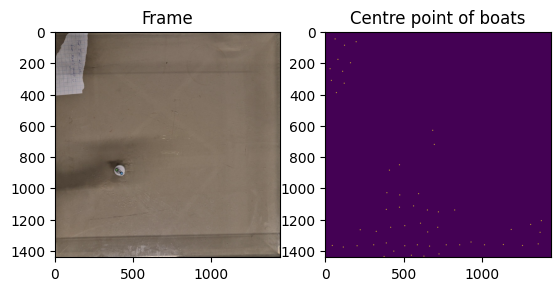

In [9]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(frames[0])
axs[0].set_title('Frame')
axs[1].imshow(frames_full[0])
axs[1].set_title('Centre point of boats')

The cell below will search for all the dots we put in the frames and save their positions.

In [10]:
f = tp.batch(frames_full,diameter=9,minmass=20, processes=1, invert=False)#37

Frame 24: 103 features


We've now got locations for all our dots! But to get information on the movement of the boats it is important that we can label boats. The code snippet below will compare all our dots frame by frame and detect which ones are which boat.

In [11]:
search_range = 140 
memory       = 20

t = tp.link(f, search_range=search_range, memory=memory)# WAS 90
# t1 = tp.filter_stubs(t, 50)
# t1['t']=t1['frames']

SubnetOversizeException: Subnetwork contains 41 points

In [ ]:
t

We've now got the trajectory of our boats! :D

In [ ]:
plt.axes().set_aspect('equal')
if t['particle'].max() != 0:
    for i in np.arange(0, t['particle'].max()):
        tt = t.loc[t['particle']==0]
        plt.plot(tt['x'], tt['y'], label = i)
else:
    tt = t.loc[t['particle']==0]
    plt.scatter(tt['x'], tt['y'], c = tt['frame'], s = 0.7)
    plt.plot(tt['x'], tt['y'], color = 'black', zorder = -10, linewidth = 0.5)
plt.imshow(frames[0], zorder = -20)
plt.legend()

In [ ]:
if t['particle'].max() != 0:
    for i in np.arange(0, t['particle'].max()):
        tt = t.loc[t['particle']==i]
        plt.plot(tt['frame'], np.sqrt(tt['y']**2 + tt['x']**2), label = i)
else:
    plt.plot(tt['frame'], np.sqrt(tt['y']**2 + tt['x']**2), label = 0)
plt.legend()

## Average speed

In [ ]:
displacement = []
averageSpeed = []
for i in np.arange(0, t['particle'].max()):
    tt = t.loc[t['particle'] == i]
    S = 0 
    for j in np.arange(0, len(frames)):
        ds = np.sqrt(tt['x']**2 + tt['y']**2)
        S = S + ds
    displacement.append(S)
    averageSpeed.append(S/duration)

In [ ]:
data = {
    'particle': np.arange(0,t['particle'].max()),
    'displacement' : displacement,
    'averageSpeed' : averageSpeed,
    
}

df = pd.DataFrame(data)

In [12]:
import skimage
from skimage import filters, morphology, color, transform, restoration, feature,measure
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed

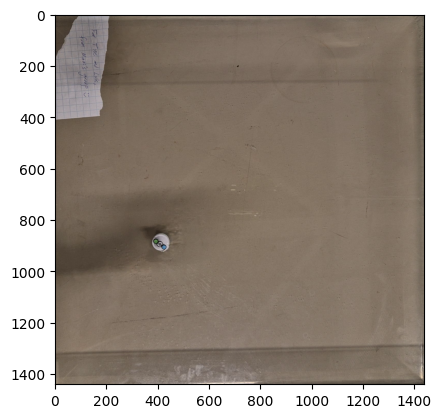

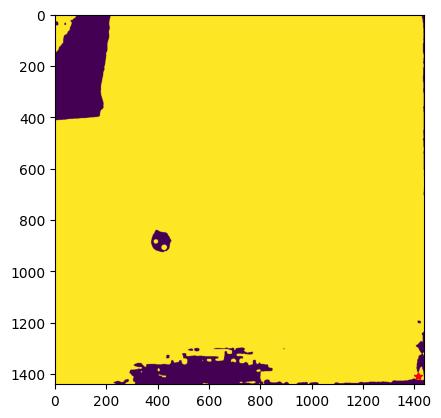

[1416]
[]


C:\Users\tiesb\AppData\Local\Temp\ipykernel_65800\368432111.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  im_mask[np.max([0,int(cyi-radius)]):np.min([int(cyi+radius),np.shape(im)[0]]),np.max([0,int(cxi-radius)]):np.min([int(cxi+radius),np.shape(im)[1]])]=1 #look only around partice positions


IndexError: index 0 is out of bounds for axis 0 with size 0

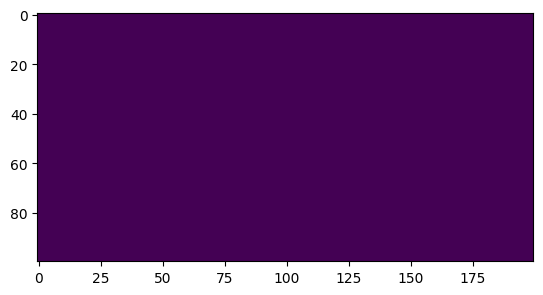

In [13]:
i=0
particle_num=1
radius = [15]
thresh=None
plt.figure()
plt.imshow(frames[i])
plt.show()

r,gr,b = frames[i][:,:,0],frames[i][:,:,1],frames[i][:,:,2]
red=(abs((r/np.max(r))-(gr/np.max(gr)))+abs((gr/np.max(gr))-(b/np.max(b)))+abs((r/np.max(r))-(b/np.max(b)))) #map colors to red -> white, else->black
gre=(abs((gr/np.max(gr))-(r/np.max(r)))-abs((r/np.max(r))-(b/np.max(b)))+abs((gr/np.max(gr))-(b/np.max(b)))) #map colors to set green -> white
blu=abs((r/np.max(r))-(b/np.max(b)))+abs((gr/np.max(gr))-(b/np.max(b)))-abs((gr/np.max(gr))-(r/np.max(r))) #map colors to set blue -> white

red = filters.gaussian(red,sigma=3)
if thresh is None:
    thresh = skimage.filters.threshold_otsu(red)
    
binary_red = np.zeros(np.shape(red))
binary_red[red>thresh]=1

area = np.sum(binary_red)
if radius is None:
    radius = [np.sqrt(area/np.pi)] #create radius by the pixle size of the masked object

circles = transform.hough_circle(binary_red,radius=radius)
accums, cx, cy, rad = transform.hough_circle_peaks(circles, radius, total_num_peaks=particle_num)

plt.figure()
plt.imshow(binary_red)
plt.plot(cx,cy,marker='*',c='r')
plt.show()

#check blue and green channels
for i,im in enumerate([gre,blu]):
    im = filters.gaussian(im,sigma=3)
    im_mask = np.zeros(np.shape(im))
    print(cx)
    for cxi,cyi in zip(cx,cy):
        im_mask[np.max([0,int(cyi-radius)]):np.min([int(cyi+radius),np.shape(im)[0]]),np.max([0,int(cxi-radius)]):np.min([int(cxi+radius),np.shape(im)[1]])]=1 #look only around partice positions
    im*=im_mask
    thresh_peak = filters.threshold_otsu(im)
    coord = peak_local_max(im, min_distance=int(radius[0]),threshold_abs=thresh_peak,num_peaks=particle_num)
    print(coord)
    plt.figure()
    plt.imshow(im[0:100,800:1000])
    plt.plot(coord[0,1]-800,coord[0,0],marker='*',color='r')
    plt.show()

In [14]:
def spot_detection_3points(frames,shorten=1,reducefps=12,radius=[40],thresh=None,particle_num=1):
    """This script reads frames from a .mp4 file, transforms channels, 
    such that blue and red are mapped to dark, black is mapped to white. 
    Filtering, thresholding, Hough Circle transform
    Final positions are centres of the Hough Circles

    Args:
        file_name (Path) : Path to raw data (.mp4 file)
        shorten   (int, default: 1)  : quotient by which time series is shortened
        reducefps (int, default: 12)  : every Nth step only used, 
        radius (list of int, default: [30,32]) : Radii to test for Hough transform

    Returns:
        pandas Dataframe: with positions 'x','y' and time 'frame','t'
    """
    x=[]
    y=[]
    xg=[]
    xb=[]
    yg=[]
    yb=[]
    radii=[]
    a=[]
    t=[]
    for i in range(0,int(len(frames)/shorten),reducefps):
        r,gr,b = frames[i][:,:,0],frames[i][:,:,1],frames[i][:,:,2]
        red=(abs((r/np.max(r))-(gr/np.max(gr)))+abs((gr/np.max(gr))-(b/np.max(b)))+abs((r/np.max(r))-(b/np.max(b)))) #map colors to red -> white, else->black
        gre=(abs((gr/np.max(gr))-(r/np.max(r)))-abs((r/np.max(r))-(b/np.max(b)))+abs((gr/np.max(gr))-(b/np.max(b)))) #map colors to set green -> white
        blu=-abs((gr/np.max(gr))-(r/np.max(r)))+abs((r/np.max(r))-(b/np.max(b)))+abs((gr/np.max(gr))-(b/np.max(b))) #map colors to set blue -> white
        red = filters.gaussian(red,sigma=2)
        
        if thresh is None:
            thresh = skimage.filters.threshold_otsu(red)
        binary_red = np.zeros(np.shape(red))
        binary_red[red>thresh]=1   
        
        area = np.sum(binary_red)/particle_num
        
        if radius is None:
            radius = [np.sqrt(area/np.pi)] #create radius by the pixle size of the masked object

        circles = transform.hough_circle(binary_red,radius=radius)
        accums, cx, cy, rad = transform.hough_circle_peaks(circles, radius, total_num_peaks=particle_num)

        #check blue and green channels
        for j,im in enumerate([gre,blu]):
            im = filters.gaussian(im,sigma=3)
            im_mask = np.zeros(np.shape(im))
            for cxi,cyi in zip(cx,cy):
                im_mask[np.max([0,int(cyi-radius)]):np.min([int(cyi+radius),np.shape(im)[0]]),np.max([0,int(cxi-radius)]):np.min([int(cxi+radius),np.shape(im)[0]])]=1 #look only around partice positions
            im*=im_mask
            thresh_peak = filters.threshold_otsu(im)
            
            
#             plt.figure()
#             plt.imshow(im)
#             plt.show()
            
            
            coord = peak_local_max(im, min_distance=int(radius[0]),threshold_abs=thresh_peak,num_peaks=particle_num)
            
            
#             print(coord)
#             plt.figure()
#             plt.imshow(im[:200,800:1000])
#             plt.plot(coord[0,1]-800,coord[0,0],marker='*',color='r')
#             plt.show()
            
            
            if j==0:
                xg.extend(coord[:,1])
                yg.extend(coord[:,0])
            else:
                xb.extend(coord[:,1])
                yb.extend(coord[:,0])
        x.extend(cx)
        y.extend(cy)
        radii.extend(rad)
        a.extend(accums)
        t.extend([i/reducefps]*particle_num)
#     print(t)

#     print(len(y))
    p = pd.DataFrame({'y': [*y],
                      'x': [*x],
                      'xb': [*xb],
                      'xg': [*xg],
                      'yb': [*yb],
                      'yg': [*yg],
                      'frame': [*t] ,
                      't': [*t]})
    
    return p

In [15]:
len(frames)

300

In [16]:
p = spot_detection_3points(frames,  thresh = 0.9,radius = None, reducefps=1)

C:\Users\tiesb\AppData\Local\Temp\ipykernel_65800\3874495728.py:60: RuntimeWarning: When min_distance < 1, peak_local_max acts as finding image > max(threshold_abs, threshold_rel * max(image)).
  coord = peak_local_max(im, min_distance=int(radius[0]),threshold_abs=thresh_peak,num_peaks=particle_num)


ValueError: All arrays must be of the same length

In [ ]:
plt.scatter(p['x'], p['y'], s = 5, color = 'black')
plt.scatter(p['xb'], p['yb'],s = 0.9, color = 'blue')
plt.scatter( p['xg'],p['yg'], s = 0.9, color = 'green')
plt.imshow(frames[0])

In [ ]:
fig, ax = plt.subplots()
ax.scatter(p['xg'], p['yg'], color = 'lawngreen')
ax.scatter(p['xb'], p['yb'], color = 'dodgerblue')
ax.scatter(p['x'], p['y'], color = 'red')
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
def displacement(dataframe):
    totalFrames = len(dataframe['t'])
    displacementList = []
    
    for i in np.arange(0, totalFrames - 1):
        data1 = dataframe.loc[dataframe['frame'] == i]
        data2 = dataframe.loc[dataframe['frame'] == i + 1]
        
        ds = np.sqrt( (data2.iloc[0]['x']-data1.iloc[0]['x'])**2  + (data2.iloc[0]['y']-data1.iloc[0]['y'])**2)

        displacementList.append(ds)
        
    return displacementList

In [ ]:
displacementList = displacement(p)

In [ ]:
displacementList

In [ ]:
plt.scatter(p['frame'][:-1],displacementList)
plt.title('distance')
plt.show()

In [ ]:
def angle(dataframe):
    totalFrames = len(dataframe['t'])
    angleList = []
    
    for i in np.arange(0, totalFrames):
        data = dataframe.loc[dataframe['frame'] == i]
        dx = data.iloc[0]['xb'] - data.iloc[0]['xg']
        dy = data.iloc[0]['yb'] - data.iloc[0]['yg']
        angle = np.arctan(dy/dx)
        angleList.append(angle)
        
    return angleList

In [ ]:
angles = angle(p)

In [ ]:
plt.plot(p['frame'], angles)
plt.xlabel('frame')
plt.ylabel('angle')
plt.show()

In [ ]:
plt.plot(p['frame'],p['yg'], color = 'lawngreen')
plt.plot(p['frame'],p['yb'], color = 'dodgerblue')
plt.plot()